## Spikelib

Este es un "paquete" (entre comillas porque no es del todo un paquete, sólo es un archivo con un par de clases) para facilitar el procesamientos de datos de electrofisiología. Como fue construido para un proyecto en particular, no es super felxible y hay muchas cosas que están pensadas y diseñasdas en función de ese proyecto.

La librería tiene esencialmente una función que deben importar, `load_data` a la cual deben pasarle la ruta a un archivo en formato .abf. Les va a devolver un `pandas.DataFrame` con una cantidad de métodos para el análisis y algunas comodidades más.

Perimero, este paquete, como dije, lee archivos .abf. Para hacer eso yo no escribí el código pertinente, sino que uso la biblioteca externa [pyABF](https://swharden.com/pyabf/) ([aquí](https://github.com/swharden/pyABF/tree/06247e01ca3c19f5419c3b9b2207ee544e30dbc5) les dejo el GitHub). Si van a usar este código en su análisis, cuando publiquen deben citar pyABF como indica en la página.

---
### Instalación

Como dije, esto no es un paquete del todo, así que la "instalación" consiste en clonar el repositorio de github:

https://github.com/mwappner/SpikeLib

y poner `spikelib.py` y `utils.py` en la misma carpeta en la que tienen el archivo de análisis de datos. Además, van a tener que instalar las dependencias a mano. Recomeindo que hagan un environment nuevo

```python
conda create -n test
conda activate test
conda install --file dependencies.yml
pip install --upgrade pyabf
conda install anaconda::openpyxl
```

---
### Ejemplo - modo de empleo
Veamos primero un ejemplo super simple, tomado de un recording de Flor. El archivo tiene dos canales y un solo sweep. Vamos a filtrarlo y visualizarlo.

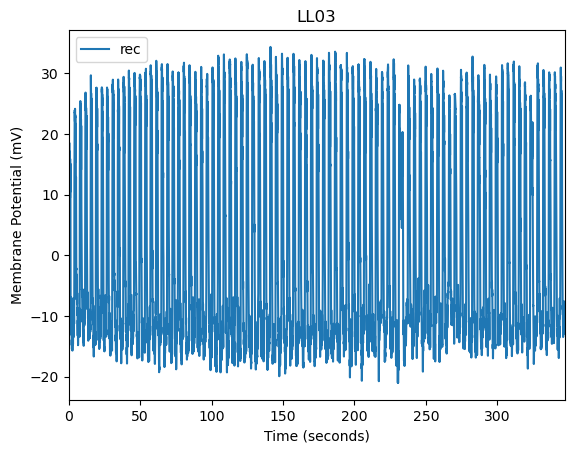

In [11]:
from spikelib import load_data

# Cargamos el archivo
file = '/home/marcos/Documents/Spikelib/test_data/flor/LL03.abf'
data = load_data(file, channel=1)
data.process.highpass_filter(frequency_cutoff=0.1)
data.process.lowpass_filter(frequency_cutoff=10)

ax = data.process.plot()

Si bien este gráfico no es fantástico, vemos que viene bien para visualizar el archivo. Viene ya rotulado con lo que pyABF define que es cada cantidad, el nombre del archivo y alguna cosita más. En general es recomendable que armen sus propias funciones de ploteo (esto aplica para cualquier paquete), pero acá, cuando pueda, vamos a usar esta, porque es cómodo.

Veamos ahora cómo podría ser un pipeline de análisis para estods datos. Voy a graficar los datos dos veces, con distintos niveles de zoom para que se entienda qué sucede a cada escala. Para esto usamos el hecho de que la función plot me deja pasarle un eje sobre el cual voy a graficar los datos.

(53.0, 55.0)

/home/marcos/anaconda3/envs/fly/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/marcos/anaconda3/envs/fly/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


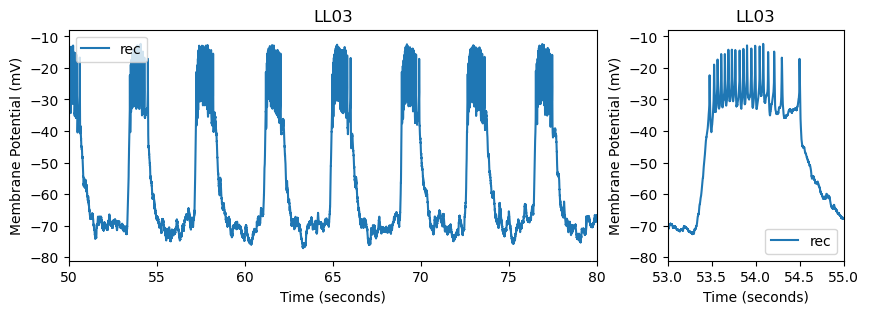

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from spikelib import load_data

file = '/home/marcos/Documents/Spikelib/test_data/flor/LL03.abf'
data = load_data(file, channel=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), width_ratios=[3,1])
data.process.plot(ax=ax1)
ax1.set_xlim(50, 80)

data.process.plot(ax=ax2)
ax2.set_xlim(53, 55)

Bien, vemos que son bursts montados sobre una oscilación del potencial de membrana. Para este recording nos interesaba saber la frecuencia de bursting. Para extraer eso queremos ver cuándo el recording corta una valor de referencia y mirar la distancia entre esos cortes. Todos esos potenciales de acción son básicamente ruido para lo que nosotros queremos mirar. Vamos a deshacernos de ellos con un filtro pasabajos.

Además, habrán notado que plotear tarda un buen rato. Esto es simplemente porque hay muchos puntos que plotear. De hecho, para el análisis que necesitamos hacer, no es necesario trabajar con tanta definición temporal. Podemos directamente hacer un _downsamplig_ (tomar uno de cada `n` puntos) y acelerar un poco todo. 

(50.0, 60.0)

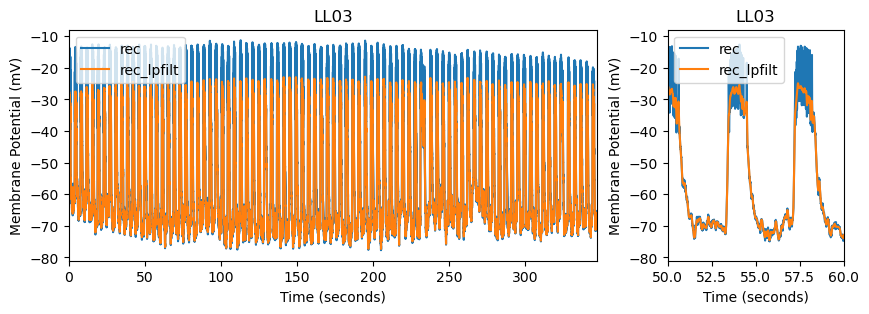

In [13]:
data.process.downsample(downsampling_rate=20)
data.process.lowpass_filter(frequency_cutoff=10, keep_og=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), width_ratios=[3,1])
data.process.plot('all', ax=ax1)
data.process.plot('all', ax=ax2)
ax2.set_xlim(50, 60)

Vemos que con el argumento `keep_og=True` ("keep original"), los datos filtrados se escriben en una nueva columna, en vez de sobreescribir los originales. Ahora sí, podemos calcular la distancia entre los bursts. Elijamos alguna altura por la que todos los bursts pasen correctamente. Por ejemplo, -50mV. Vamos a tener que especificar sobre qué columna queremos aplicar este paso.

In [14]:
crossings = data.process.get_crossings(edge='rising', threshold=-50, column='lpfilt')

AssertionError: You must find peaks first

Ups! La función nos avisa que, por cómo está escrita necesita que primero corramos una función para hallar los picos de la señal. Por supuesto que ustedes pueden reescribir `get_crossings` para que funcione de otra forma.

You've already calculated peaks before. Overriding the previous one.


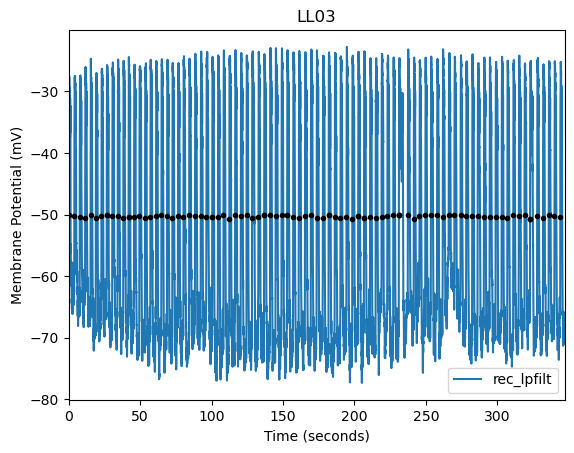

In [18]:
data.process.find_peaks(column='lpfilt')
crossings = data.process.get_crossings(edge='rising', threshold=-50, column='lpfilt')

ax = data.process.plot('rec_lpfilt')
ax.plot(data.times.values[crossings], data.rec_lpfilt.values[crossings], '.k')

Habiendo corroborado que funcionó bien el conjunto de parámetros que elegí, calculo finalmente la distancia media entre bursts para estimar el período y, de ahí, la frecuencia.

In [22]:
crossing_times = data.times.values[crossings]
period = np.diff(crossing_times).mean()
frequency = 1/period

print(f'Frequency: {frequency:.2f}Hz')

Frequency: 0.28Hz


Para terminar, apliquemos este mismo análisis a todos los registros que tenemos. Una vez que hayan diseñado su _pipeline_ de análisis, algo como esto va a ser **todo el código** que van a nacesitar.

In [45]:
from utils import contenidos
import pandas as pd

data_dir = '/home/marcos/Documents/Spikelib/test_data/flor'
data_files = contenidos(data_dir, filter_ext='.abf')

results = []
for i, file in enumerate(data_files):
    print(f'Running file {file.stem}: {i+1}/{len(data_files)}')
    
    # load data
    data = load_data(file)
    
    # filter it
    data.process.downsample(downsampling_rate=20)
    data.process.lowpass_filter(frequency_cutoff=10)
    data.process.highpass_filter(frequency_cutoff=0.2)
    
    # find peaks and crossings
    data.process.find_peaks()
    crossings = data.process.get_crossings(edge='rising', threshold=5)
    
    # save data
    crossing_times = data.times.values[crossings]
    frequency = 1/np.diff(crossing_times).mean()
    results.append((file.stem, frequency))

# convert to dataframe and check out the first few entries
df = pd.DataFrame(results, columns=['file', 'frequency'])
print(df.head())

# save data
savedir = file.parent
df.to_csv(savedir / 'frequencies.csv', index=False)

Running file LL01: 1/34
Running file LL02: 2/34
Running file LL03: 3/34
Running file LL04: 4/34
Running file LL05: 5/34
Running file LL06: 6/34
Running file LL07: 7/34
Running file LL08: 8/34
Running file LL09: 9/34
Running file LR01: 10/34
Running file LR02: 11/34
Running file LR03: 12/34
Running file LR04: 13/34
Running file LR05: 14/34
Running file LR06: 15/34
Running file LR07: 16/34
Running file LS01: 17/34
Running file LS02: 18/34
Running file LS03: 19/34
Running file LS04: 20/34
Running file LS05: 21/34
Running file LS06: 22/34
Running file LS07: 23/34
Running file LS08: 24/34
Running file LS09: 25/34
Running file LS10: 26/34
Running file LS11: 27/34
Running file LS12: 28/34
Running file LS13: 29/34
Running file LS14: 30/34
Running file LS15: 31/34
Running file LS16: 32/34
Running file LS17: 33/34
Running file LS18: 34/34
   file  frequency
0  LL01   0.520198
1  LL02   0.480200
2  LL03   0.279157
3  LL04   0.623175
4  LL05   0.480200


Y tenemos los datos guardados para lo que queramos hacer más adelante.

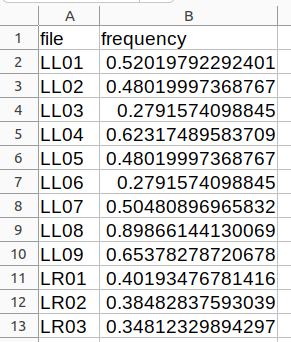

---
### Metadata, planilla de anotaciones y step info

Algo que siempre sucede es que a medida que hacemos registros vamos haciendo anotaciones relevantes. Pueden ser comentarios sobre le registro ("Esta neurona estaba en tal parte del cerebro", "Inicio de aplicación de la droga a los 13 minutos de registro") o cosas más cuantitativas, como qué tipo de neurona estoy registrando. Si somos un poquito ordenades y anotamos todo esto en un excel donde nos aseguramos de tener una columna que sea el nombre del archivo, el paquete carga automáticamente esta info y la guarda en el atributo `metadata`.
Por ejemplo, en este caso Flor anotó qué tipo de célula (S, L, R) registró en cada canal.

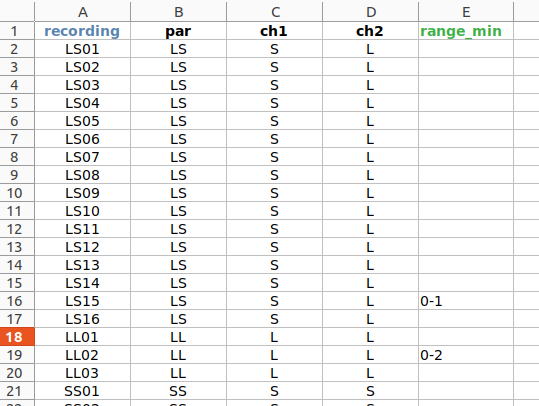

El archivo puede estar en cualquiera de los siguientes formatos: .xls, .xlsx, .xlsm, .xlsb, .odf, .ods, .odt, .csv.
Toda la info que pongan acá es arbiraria, puede ser lo que ustedes quieran, puede haber filas vacías si necesitan. Lo que sí es importante es que haya una columna llamada `recording`, que resalté en azul, y que el contenido sea el nombre del archivo, respetando mayúsculas y minúsculas, y _sin la extensión_ `.abf`. Además, es **importantísimo** que usen como separador desimal el punto y no la coma. Es decir, "1.4" y no "1,4".

Este excel debe estar guardado en _la misma carpeta_ que los datos y debe llamarse `info.csv` (o `.xlsx` o lo que sea).

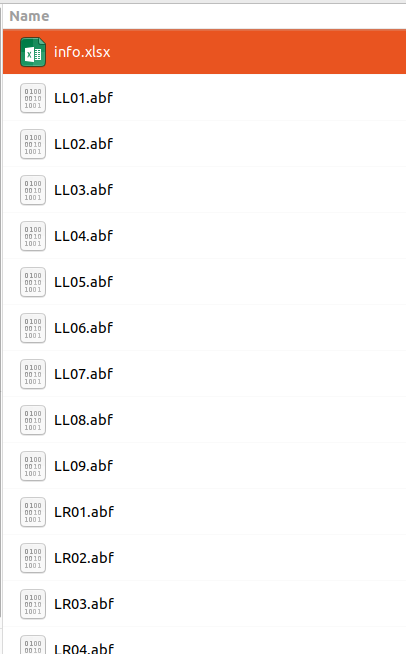

In [12]:
from utils import contenidos
from spikelib import load_data

data_dir = '/home/marcos/Documents/Spikelib/test_data/flor'
data_files = contenidos(data_dir, filter_ext='.abf')

data1 = load_data(data_files[17])
data1.metadata

par: LS
ch1: S
ch2: L
range_min: nan

channel count: 2
channel: 0
sweep count: 1
recording length (sec): 1023.2831500000001
recording date: 2019-11-15 13:00:57.781000
protocol: current clamp (gap free new)
sampling rate (Hz): 20000
file: /home/marcos/Documents/Spikelib/test_data/flor/LS02.abf

In [13]:
data2 = load_data(data_files[1], channel=1)
data2.metadata

par: LL
ch1: L
ch2: L
range_min: 0-2

channel count: 2
channel: 1
sweep count: 1
recording length (sec): 119.99990000000001
recording date: 2022-05-27 20:13:50.359000
protocol: gap free 2 channels
sampling rate (Hz): 10000
file: /home/marcos/Documents/Spikelib/test_data/flor/LL02.abf

Vemos dos bloques de info: el primero está tomado de las columnas de la planilla de cálculo, el segundo es info que le paquete se encarga de rescater directamente del archivo de registro. Podemos acceder también de forma independiente a cada atributo de esta forma:

In [14]:
data2.metadata.ch2

'L'

Como hay cosas que _Python_ no deja usar como nombre de variable, internamente algunas cosas no se llaman exáctamente como en la tabla de excel. Además, van a querer acceder a la infor que el paquete guarda de forma automática. Para saber cómo se llaman internamente, pueden chusmear el _contenido_ de metadata:

In [15]:
print(data1.metadata.contents)

('par', 'ch1', 'ch2', 'range_min', 'channel_count', 'channel', 'sweep_count', 'sweep', 'sweep_duration_sec', 'duration', 'rec_datetime', 'protocol', 'raw_sampling_rate', 'sampling_rate', 'file')


In [16]:
data1.metadata.sampling_rate

20000

Con acceso a esta info vamos a poder hacer análisis distinto para cada tipo de neurona o graficar con distintos colores o lo que queramos. Siempre está bueno tener acceso fácil a todas nuestra info.

Vemos en la tabla también que algunos de los registros tienen info en la columna `range_min`, que resalté en verde. Esta es otra columna especial, como `recording` que para que funcione debe ser escrita de esta forma exacta. El objetivo de esta columna es recortar los datos cargados. Por ejemplo, si saben que hicieron un recording largo donde al comienzo hicieron un resgistro de la actividad basal y después le aplicaron algún tratamiento pueden cargar sólo la parte de la actividad basal especificando qué rango usar en esa columna. Miremos nuevamente el último registro que cargamos. Vemos que en la metadata está la columna y la duración refleja este recorte:

In [17]:
print('intervalo usado (min):', data2.metadata.range_min)
print('duración (sec):', data2.metadata.duration)

intervalo usado (min): 0-2
duración (sec): 119.99990000000001


Vemos que en efecto el paquete recortó (casi) 120 segundos de registro, en vez de cargarlo todo.

Finalmente, este es un momento tan bueno como cualquier otro para contarles sobre esto: así como `.metadata` guarda info sobre el registro, `.process.info` guarda info sobre los pasos de procesado que fueron realizados. Hay tres formas de acceder a esta información en distintos niveles de profundidad. Primero carguemos unos datos y hagámosle algunas cosas.

In [24]:
data = load_data(data_files[1], channel=1)
data.process.lowpass_filter(frequency_cutoff=10)
data.process.highpass_filter(frequency_cutoff=0.1)
data.process.downsample(10)
data.process.lowpass_filter(frequency_cutoff=2, keep_og=True)
data.process.find_peaks(column='lpfilt')

Lo primero que podemos ahcer es mirar los pasos de análisis que fueorn hecho sobre estos datos, sin más info:

In [21]:
data.process.steps

('lpfilt', 'hpfilt', 'downsampling', 'lpfilt', 'findpeaks')

Es una tupla con los nombres de todos los pasos de análisis realizados. Después podemos agarrar alguno de estos pasos y medir la info completa, que nos dice exáctamente con qué parámetros fue llamada la función en cuestión. Por ejemplo:

In [25]:
data.process.get_step_info('lpfilt')

{'step': 'lpfilt',
 'filter_order': 2,
 'frequency_cutoff': 2,
 'border_effects': True,
 'keep_og': True,
 'column': ''}

Acá tenemos la info del último filtro aplicado en forma de un diccionario. Cómo sé que es el último? Porque tiene `frequency_cutoff=2`. De hecho podemos ver los valores de todos los parámetros, incluso los que tienen valores por defecto que no modificamos en el llamado explícitamente. Podríamos reproducir este paso de procesado haciendo simplemente `data.process.lowpass_filter(**data.process.get_step_info('lpfilt'))` Y cómo hacemos si queremos ver el otro filtro que aplicamos? Podemos simplemente llamar a la función `get_step_info` y pedirle que no nos muestre sólo el último:

In [26]:
data.process.get_step_info('lpfilt', last=False)

({'step': 'lpfilt',
  'filter_order': 2,
  'frequency_cutoff': 10,
  'border_effects': True,
  'keep_og': False,
  'column': ''},
 {'step': 'lpfilt',
  'filter_order': 2,
  'frequency_cutoff': 2,
  'border_effects': True,
  'keep_og': True,
  'column': ''})

Qué hacemos con esta info ahora va a depender de nosotres. La última forma de acceder a esta información, la más completa pero menos estructurada es simplemente acceder la lista de pasos ordenados, donde cada elemento de la lista es un diccionario como los de arriba:

In [27]:
data.process.info

({'step': 'lpfilt',
  'filter_order': 2,
  'frequency_cutoff': 10,
  'border_effects': True,
  'keep_og': False,
  'column': ''},
 {'step': 'hpfilt',
  'filter_order': 2,
  'frequency_cutoff': 0.1,
  'border_effects': False,
  'keep_og': False,
  'column': ''},
 {'step': 'downsampling', 'downsampling_rate': 10, 'inplace': True},
 {'step': 'lpfilt',
  'filter_order': 2,
  'frequency_cutoff': 2,
  'border_effects': True,
  'keep_og': True,
  'column': ''},
 {'step': 'findpeaks',
  'prominence': 5,
  'period_percent': 0.6,
  'column': 'lpfilt'})

Usualmente esto no es necesario para ver qué le hicieron a los datos, porque para eso pueden simplemente el código, sino para que _el paquete_ sepa qué le hicieron a los datos. Esta info a veces es necesaria cuando quieren escribir su propia función de análisis. Por ejemplo, en mi implementación de cálculo de cruces de un valor umbral (como usé arriba y como veremos más abajo) es necesario hallar los picos de una señal antes de calcular los cruces. Para eso uso la fución `data.process._check_if_action_was_performed_on_column(action, column)` que utiliza las cosas que les acabo de mostrar.

---

### Ejemplo - sweeps y baseline

Vamos a mirar ahora unos datos de Agus. En sus registros ella hace tres sweeps durante los cuales va inyectando progresivamente más corriente negativa. Veamos un registro.

celltype: L
range_min: nan
Aplicación daf: sí
Obs: nan
Comentarios: Un poco a la derecha del aMe, no sé si selló bien

sweep count: 3
sweep length (sec): 93.0
recording length (sec): 278.9999
recording date: 2023-10-24 16:02:57.765000
protocol: hiperpol 3.6.9pA
original sampling rate (Hz): 10000
sampling rate (Hz): 100
file: /home/marcos/Documents/Spikelib/test_data/agus/agus01.abf

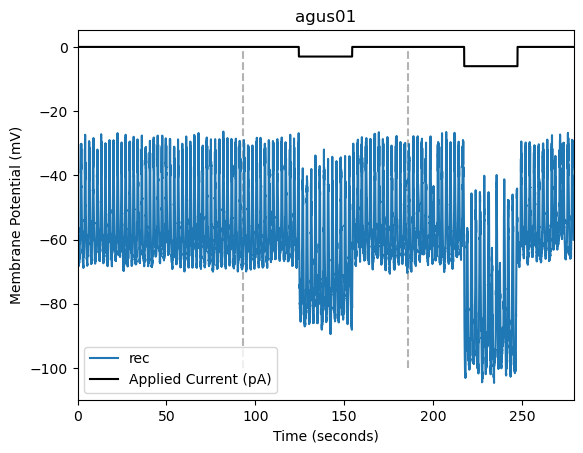

In [1]:
from spikelib import load_data
import matplotlib.pyplot as plt

file = '/home/marcos/Documents/Spikelib/test_data/agus/agus01.abf'
data = load_data(file)
data.process.downsample(100)

ax = data.process.plot()
sweep_dur = data.metadata.sweep_duration_sec
ax.vlines((sweep_dur, sweep_dur*2), -100, 0, linestyles='--', colors='0.7', zorder=1)
data.metadata

En la metadata vemos que hace tres sweeps de 93 segundos cada uno aplicando el protocolo "hiperpol 3.6.9pA". En el gráfico vemos que en el primer sweep (agregué líneas punteadas apra marcar el fin de un sweep y comienzo del siguiente) no inyecta corriente, en el segundo inyecta un poco y en el tercero un poco más. Esta info está en la columna `pert` del dataframe. Habrá que inspeccionarla para ver cuál es la corriente palicada exactamente (o preguntarle a Agus).

Supongamos ahora que lo que quiere ver es cómo cambia el valor basal de membrana antes de aplicar corriente, para después usarlo de valor de referencia. Para esto podemos ir a mirar directo el último sweep y estimar ese valor. Vamos a cargar los datos de nuevo, pero especificando qué sweep, como antes hicimos con el canal, cuando miramos los datos de Flor. Recordemos que los sweeps (y canales) arrancan la numeración en 0, así que el primer sweep es `sweep=0`.

Vamos a usar la función de análisis `calc_baselines` para obtener el valor y `calc_multi_baselines` para tener algo que graficar, para chequear que el algoritmo esté funcionando como creemos. Y cómo hacemos para saber cómo usarla? Pues simple, le pedimos ayuda (?)

In [12]:
data = load_data(file, sweep=0)
data.process.downsample(50)
help(data.process.calc_baseline)

Help on method calc_baseline in module spikelib:

calc_baseline(column='', drop_quantile=0.5) method of spikelib.Processors instance
     Uses calc_baseline_in_one_bit to calculate the baseline of the data 
     given in column. See that function for a more detailed description.
    
     Parameters
     ----------
    column : str, optional
        A string describing what column to apply the funciton on. The 
        default is ''.
     drop_quantile : float, optional
         Quantile under which to drop the minima. Should be between 0 and 1.
         0.5 means drop everything over the median. The default is 0.5.
    
     Returns
     -------
     float
         Value of the baseline.



Vemos que lo único que hay que hacer es pasarle la columna sobre la que queremos actuar y que podemos especificar algunos parámetros de cómo funciona para ajustar el comportamiento de la función si no ahce lo que queremos. Como no aplicamos ningún filtro, no necesitamos especificar la columna.

**NOTA:** Todas las funciones de procesado te permiten especificar la columna a la cual se aplican. La forma en que se lo especifica es con un _string_ que indica qué pasos de procesamiento se le aplicó. Es decir, no es el nombre completo de la columna, sino lo que viene después de `rec`. Por eso `''` es la columna sin nada aplicado.

Baseline (mV): -65.39865558067065


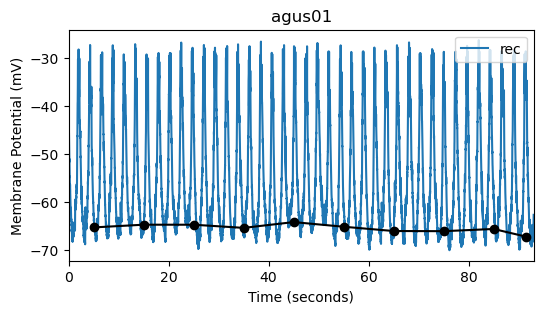

In [14]:

btimes, bvals = data.process.calc_multi_baseline(length=10)

fig, ax = plt.subplots(figsize=(6,3))
data.process.plot(ax=ax)
ax.plot(btimes, bvals, '-ok')

print('Baseline (mV):', data.process.calc_baseline())

Bien! Vemos que el algoritmo hace algo razonable (las líneas negras) y el valor también se ve bien.

---

### Ejemplo - cortes, detrending y spike counting

Vamos ahora a ver un ejemplo de Giulia. Ella también tiene un protocolo de inyección de corriente y queire ver la frecuencia de disparo al inyectar corriente. Chusmiemos primero los datos. 

sweep count: 15
sweep length (sec): 2.0
recording length (sec): 29.99995
recording date: 2022-10-24 17:54:40.250000
protocol: Iclamp spiking
original sampling rate (Hz): 20000
sampling rate (Hz): 400
file: /home/marcos/Documents/Spikelib/test_data/giu1.abf

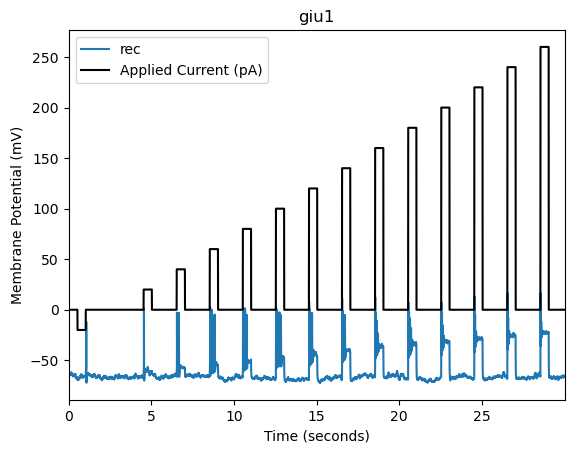

In [1]:
from spikelib import load_data
import matplotlib.pyplot as plt
import numpy as np

file = '/home/marcos/Documents/Spikelib/test_data/giu1.abf'
data = load_data(file)
data.process.downsample(50)
data.process.plot()
data.metadata

Vemos nuevamente que tenemos muchos sweeps. Esta vez queremos analizarlos todos, así que no vamos a cargar uno solo. Lo que sí quiero es intentar aislar los datos en cada uno de los momentos de inyecceión de corriente. Para eso voy a extraer esos momentos usando la línea negra como referencia.

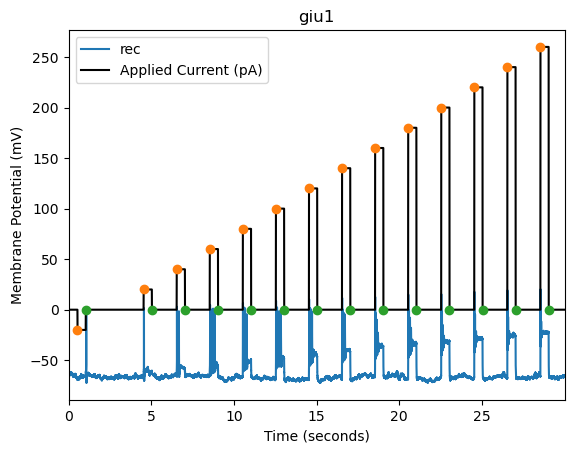

In [2]:
data = load_data(file)
pert_diff = data.pert.diff()
start = np.flatnonzero(pert_diff > 1)
end = np.flatnonzero(pert_diff < -1)

start[0], end[0] = end[0], start[0]

ax = data.process.plot()
ax.plot(data.times[start], data.pert[start], 'o')
ax.plot(data.times[end], data.pert[end], 'o')

¡Bien! Mirando los signos de las derivadas, y con un truquito más, pudimos extraer los comienzos y finales de cada pulso. Ahora recortemos los datos. Estarán tentades a hacer algo tipo `recorte = data[from:to]`, pero hacer eso tiene el problema de que ahora `recorte` no tiene toda la metadata de `data`, que ne muchos casos es necesaria para que los métodos de `process` funcionen. Para solucionar esto existe la función `cut`, que te permite recortar un recording entre dos momentos dados.

In [3]:
help(data.process.cut)

Help on method cut in module spikelib:

cut(start, end, units='index', inplace=True) method of spikelib.Processors instance
    Cut the data in the given interval [start, end]. Units can be 
    either 'index' or 'time'. In the former case, start and end are assumed
    to be the int indexes at which the cut happens. In the latter, they are 
    assumed to be the times, and the appropiate indexes are found.



 Al igual que `downsample` esta es una función que modifica todos los datos. Como a veces no _queremos_ perder los datos originales y quermeos tener el recorte (o la versión downsampleada) y mantener los datos originales, existe el parámetro `inplace`, que está pobremente documentada. Lo que hace es decide si devuelve una copia de los datos modificados o modifica el dataframe original. En este caso, como vamos a querer muchos recortes distintos y no queremos cargar los datos cada vez usando `load_data` porque eso impicaría hacer mucho trabajo extra, vamos a usar `inplace=False`.

Text(0, 0.5, 'Membrane potential (mV)')

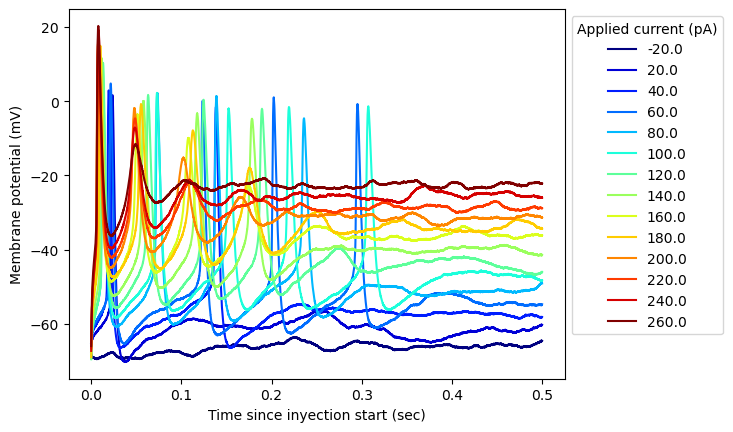

In [4]:
fig, ax = plt.subplots()
colors = plt.cm.jet(np.linspace(0, 1, start.size))
for c, start_point, end_point in zip(colors, start, end):
    snippet = data.process.cut(start_point, end_point, inplace=False)
    current = snippet.pert[0]
    
    t0 = snippet.times.values[0]
    ax.plot(snippet.times-t0, snippet.rec, c=c, label=current)
    
ax.legend(title='Applied current (pA)', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Time since inyection start (sec)')
ax.set_ylabel('Membrane potential (mV)')

Ahora queremos encontrat los picos y ver la distancia entre ellos para poder estimar la frecuencia. Una forma posible de hacerlo es literlmente hallar los picos. Esta es suceptible a ruidos así que una versión alternativa posible es filtrar un poco la señal para sacar ruido, detrendearla para que todas tengan un baseline aprecido y buscar picos mirando cuándo la señal pasa un umbral fijo. Miremos primero el tema de los filtros. Para ver qué tenemos disponible podemos acceder a `filtering`, que nos va a listar todos los filtros que hay implementados. De forma similar existen las categorías `detrending`, `event_finding` y `characteristics`, pero ustedes se pueden armar sus propias categorías.

In [5]:
data.process.filtering

lowpass_filter
gaussian_filter
highpass_filter

Vamos a usar un filtro pasabajos para eliminar ruido. Vamos a probar nuestros filtros con no solo de los pulsos, después vemos cómo fuina para el resto.

In [6]:
help(data.process.lowpass_filter)

Help on method lowpass_filter in module spikelib:

lowpass_filter(filter_order=2, frequency_cutoff=10, border_effects=True, keep_og=False, column='') method of spikelib.Processors instance
    Filter the data in channels using a lowpass butterworth filter. The order
    and frequency cutoff value can be set. It uses a forwards and a 
    backwards pass of the filter, resulting in an effective filter order
    that is twice filter_order.
    
    Parameters
    ----------
    filter_order : int, optional
        Order of the filter. The default is 2.
    frequency_cutoff : float, optional
        Frequency at which the filter drops by 3dB. The default is 10Hz.
    border_effects: Bool, optional
        Decides whether to keep border effects of mirror the data to remove,
        them at the expense of increased cost. See no_border_effects_call.
        The default is True, keeping border effects.
    keep_og : Bool, optional
        Whether to keep the original column or overwrite it. Th

Vemos que además de definir las cosas que competen a los filtros podemos, como antes, definir sobre qué columna se aplica (`column`) y podemos definir si la data filtrada va a sobreescribir la columna original o agregar una columna nueva (`keep_og`), parecido al `inplace` de `cut` y `detrend`, pero ahora para una columna nomás, en vez de todos los datos. Como queremos explorar un poco los filtros y ver qué hacen, vamos a crear una nueva columna, pero en general cuando ya tenemos aceitado el análisis, podemos hacer todo sobre la misma columna.

,times,rec,pert,rec_lpfilt,rec_lpfilt2,rec_lpfilt3
0,22.53125,-65.521240,200.0,-51.406408,-57.584442,-64.481210
1,22.53130,-65.216064,200.0,-51.310398,-57.341799,-64.241898
2,22.53135,-63.827515,200.0,-51.214360,-57.097404,-63.999643
3,22.53140,-62.438965,200.0,-51.118296,-56.851277,-63.754523
4,22.53145,-61.752319,200.0,-51.022210,-56.603437,-63.506617
...,...,...,...,...,...,...
9995,23.03100,-31.463623,200.0,-30.858991,-31.058659,-31.162422
9996,23.03105,-31.326294,200.0,-30.858993,-31.058704,-31.162711
9997,23.03110,-31.372070,200.0,-30.858995,-31.058743,-31.162961
9998,23.03115,-31.356812,200.0,-30.858997,-31.058775,-31.163173


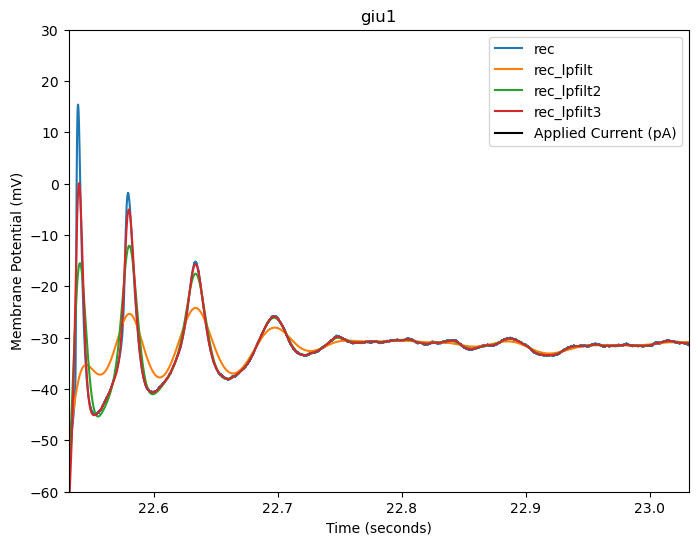

In [7]:
snippet = data.process.cut(start[-4], end[-4], inplace=False)
snippet.process.lowpass_filter(frequency_cutoff=20, keep_og=True)
snippet.process.lowpass_filter(frequency_cutoff=50, keep_og=True)
snippet.process.lowpass_filter(frequency_cutoff=100, keep_og=True)

fig, ax = plt.subplots(figsize=(8, 6))
snippet.process.plot('all', ax=ax)
ax.set_ylim(-60, 30)
snippet

Ahí vemos cómo al palicar un filtro con `keep_og=True` se generan nuevas columnas con los datos filtrados. Vemos que vamos a tener que encontrar un compromiso entre matar bien el ruido y no matar demasiado los picos. En principio me gusta el segundo filtro, con frecuencia de corte 50Hz, porque la de 100Hz es todavía demasiado ruidosa y la de 20Hz mata toda la señal. Ahora a esta misma señal (`lpfilt2`, según la leyenda) vamos a aplciarle un detrending. Para esto voy a usar un filtro pasa altos, pero ustedes pueden elegir otra de la lista disponible en `data.process.detrending`, o escribir la suya propia. Noten que tenemos que aclarar que queremos aplicarlo sobre la columna `lpfilt2`.

<AxesSubplot: title={'center': 'giu1'}, xlabel='Time (seconds)', ylabel='Membrane Potential (mV)'>

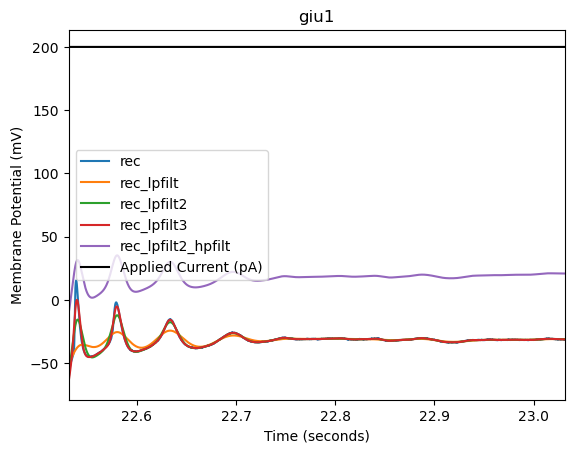

In [8]:
snippet.process.highpass_filter(frequency_cutoff=0.1, keep_og=True, column='lpfilt2')
snippet.process.plot('all')

Veamos si esto que hicimos se aplica bien a todos los cachitos que queremos analizar.

Text(0, 0.5, 'Membrane potential (mV)')

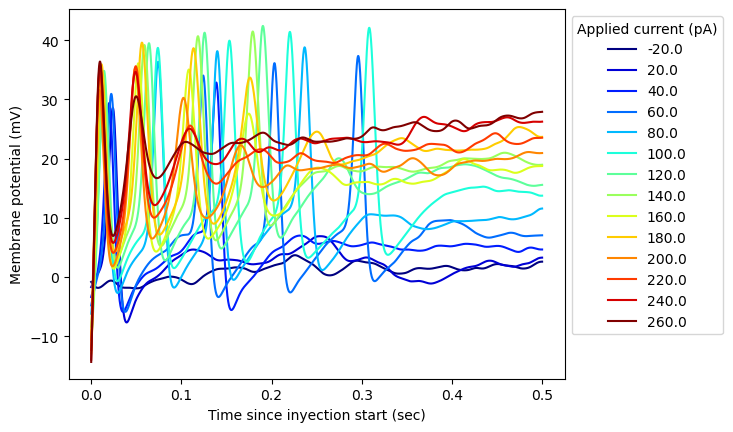

In [9]:
fig, ax = plt.subplots()
colors = plt.cm.jet(np.linspace(0, 1, start.size))
for c, start_point, end_point in zip(colors, start, end):
    # cut data
    snippet = data.process.cut(start_point, end_point, inplace=False)
    current = snippet.pert[0]
    
    # apply filters
    snippet.process.lowpass_filter(frequency_cutoff=50)
    snippet.process.highpass_filter(frequency_cutoff=0.1)
    
    # plot
    t0 = snippet.times.values[0]
    ax.plot(snippet.times-t0, snippet.rec, c=c, label=current)
    
ax.legend(title='Applied current (pA)', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlabel('Time since inyection start (sec)')
ax.set_ylabel('Membrane potential (mV)')

Siempre que desarrollamos un pipeline de análisis es buena idea ver que las cosas están funcionando. A veces eso implica un análisis visual de todos los datos, así que vamos a hacerlo al aplicar le siguiente paso. Vamos a encontrar los picos de cada cachito y después a usar esa info para hallar el momento donde cada pulso hallado cruza un valor umbral, que voy a establecer en 20mV. Probablemente para estos datos no haga falta este segundo paso, pero así les muestro cómo se hace.

It's likely no peaks were found over the given threshold value of 20. Or maybe something else is wrong. Are you sure you have peaks in 'giu1'? 


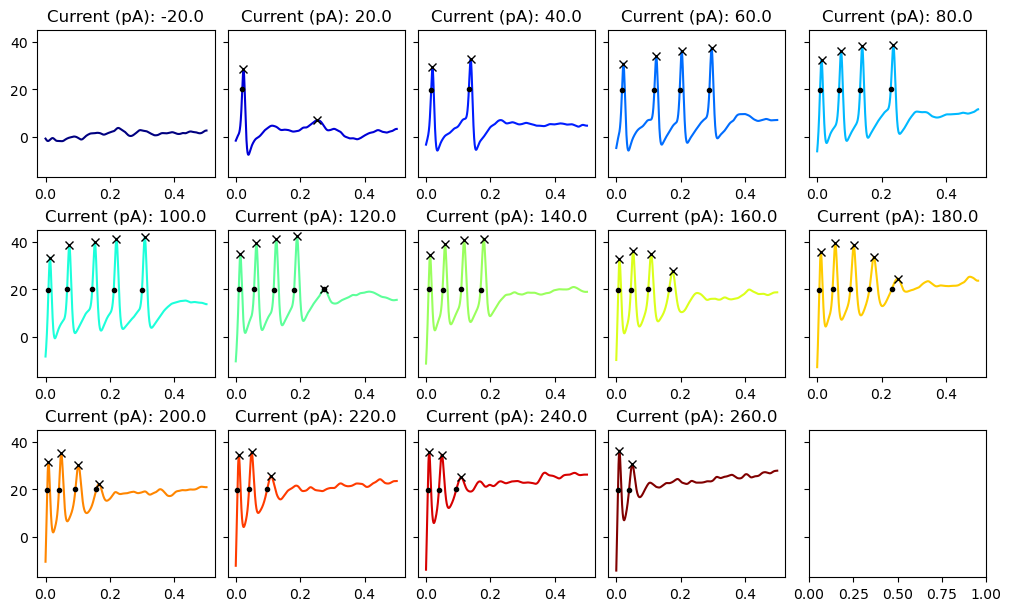

In [10]:
currents, frequencies = [], []

fig, axarr = plt.subplots(3, 5, figsize=(10, 6), constrained_layout=True, sharey=True)
colors = plt.cm.jet(np.linspace(0, 1, start.size))
for ax, c, start_point, end_point in zip(axarr.flat, colors, start, end):
    # cut data
    snippet = data.process.cut(start_point, end_point, inplace=False)
    current = snippet.pert[0]
    
    # apply filters
    snippet.process.lowpass_filter(frequency_cutoff=50)
    snippet.process.highpass_filter(frequency_cutoff=0.1)
    
    # find peaks and crossings
    snippet.process.find_peaks(period_percent=None, prominence=4)
    cindexes = snippet.process.get_crossings('rising', threshold=20)
        
    # plot
    t0 = snippet.times.values[0]
    ax.plot(snippet.times-t0, snippet.rec, c=c, label=current)
    
    ax.plot(snippet.process.get_peak_pos()-t0, snippet.process.get_peak_values(), 'kx')
    ax.plot(snippet.times[cindexes]-t0, snippet.rec[cindexes], 'k.')
    
    ax.set_title('Current (pA): ' + str(current))
    
    # save data if we have enought points to calculate the frequency
    if cindexes.size > 1:
        frequency = 1/np.mean(np.diff(snippet.times[cindexes]))
        
        currents.append(current)
        frequencies.append(frequency)
    

Genial! Vemos que nos avisó que no encontró picos en el primer cachito y después nos fue marcando los máximos y los puntos en los que corta el valor de referencia. Para terminar podemos graficar el resultado, a ver si vemos una tendencia.

Text(0, 0.5, 'Firing frequency (Hz)')

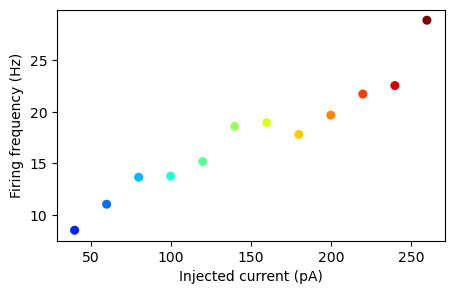

In [11]:
plt.figure(figsize=(5, 3))
plt.scatter(currents, frequencies, s=30, c=colors[2:])
plt.xlabel('Injected current (pA)')
plt.ylabel('Firing frequency (Hz)')

### Cómo funciona

- pyabf
- load steps
- pandas accessors


### Cómo agregar funciones

Hay varios tipos de funciones bajo en conjunto métodos en `process`, pero creo que si deciden agregar alguna función va a ser una de dos funciones: 
- Que modifica los datos aplicando un paso de procesamiento (filtros, detrending, etc.)
- Que extrae alguna info de los datos (hallar picos, calcular esl baseline, etc.)

#### Procesamiento

Estas funciones tienen una cantidad de código fijo que llamamos "bolierplate code" que es necesario para preservar la estructura de las funciones y los datos. Veamo por ejemplo

```python
@filtering
def gaussian_filter(self, sigma_ms=20, border_effects=True, keep_og=False, column=''):
    """
    Uses a gaussian kernel to filter data. This gives a result that is 
    absolutely equivalent to the built-in abf gaussian filter, but runs a 
    bit slower. Use this if you no longer have the abf object.

    Parameters
    ----------
    sigma_ms : float, optional
        Sigma in units of milliseconds. The default is 20.
    border_effects: Bool, optional
        Decides whether to keep border effects of mirror the data to remove,
        them at the expense of increased cost. See no_border_effects_call.
        The default is True, keeping border effects.
    keep_og : Bool, optional
        Whether to keep the original column or overwrite it. The default is
        False.
    column : str, optional
        A string describing what column to apply the funciton on. The 
        default is ''.

    Returns
    -------
    None.

    """                
    action_name = 'gfilt2'
    data = self._df
    col = self._get_column(column)

    # some filter methods leave behind nans in the data, that raises a LinAlgError
    nan_locs = np.isnan(col)

    # calculate the sigma in untis of datapoints
    sampling_rate = data.metadata.sampling_rate
    sigma_points = (sigma_ms / 1000) * sampling_rate

    # col_filt = gaussian_filter1d(col[~nan_locs], sigma_points)
    col_filt = self._no_border_effect_call(
        partial(gaussian_filter1d, sigma=sigma_points),
        col[~nan_locs],
        border_effects
        )

    self._save_processed_data(col_filt, keep_og, column, action_name)
    self._add_process_entry(action_name, sigma_ms=sigma_ms, keep_og=keep_og, column=column)        
```

1. Todas las funciones deben tomar primero los parámetros que necesite para correr y luego los que refieren a las columnas a utilizar. Vemos que la función `gaussian filter` necesita que le demos un valor a `sigma_ms` y `border_effects`, aunque la definición de la función ya establece valores por defecto. Luego tenemos
    - `keep_og` que define si, luego de generar los datos procesados, el resultado se guarda en una nueva columna o sobreescribe la anterior
    - `column` que define qué columna debe ser procesada

2. Luego tenemos la _documentación_ de la función. Es eso que Python te muestra cuando llamás `help(mifunción)`. Es optativo, pero altamente recomendable para ustedes del futuro: cuando quieran acordarse qué ahce la función y cada parámetro, van a querer haber escrito la documentación.

3. Luego arranca el código de la función con el primer cacho de boilerplate:
```python
action_name = 'gfilt2'
data = self._df
col = self._get_column(column)
```
Definimos el nombre de la acción que vamos a ejecutar. Esto es lo que se usa como nombre de columna si decidimos no sobreescribir los datos. Luego recumeramos el dataframe en sí, `data`, por si lo necesitamos, por ejemplo para acceder a la columna de tiempos `data.times` o, más comunmente, a la metadata: `data.metadata.sampling_rate`. Finalmente recuperamos la columna sobre la que vamos a trabajar. De esto se encarga `_get_column`.

4. Luego viene algo que es opcional: muchas funciones de análisis no andan bien si los datos que tenemos contienen `NaNs`, que es el valor que numpy y muchas librerías científicas usan para decir "esto no es un número". En esos casos lo que debemos hacer es pedirle a la función de análisis que llamemos que opere sólo sobre la parte que no contienen `NaNs`:
```python
nan_locs = np.isnan(col)
```
Para esto, en vez de llamar a la función sobre los valores de la columna `col`, lo hacemos sobre la columna filtrada por los sitios que _no_ contienen `NaNs`: `col[~nan_locs]` (ver el uso en el código). No se preocupen porque el resultado tenga un tamaño menos que el de la columna original, de eso se encarga el final del boilerplate.

5. Ahora sí, definimos nuestra función. Acá va su código. En el caso de `gaussian_filter` eso consistía en recuperar el sampling rate, calcular el tamaño del filtro y llamar al filtro. Este paso debe terminar con una variable que corresponda a los valores de la nueva columna, con o isn `NaNs`.

6. Finalmente, guardamos los datos procesados y registramos el paso de procesamiento que hicimos:
```python
self._save_processed_data(col_filt, keep_og, column, action_name)
self._add_process_entry(action_name, sigma_ms=sigma_ms, keep_og=keep_og, column=column)   
```
- `_save_processed_data` se encarga de guardar los nuevos datos donde corresponda, sobreescribiendo la columna original o creando una nueva, en cuyo caso el nombre será `columna original + '_' + action_name`. Debe ser llamado con los datos a guardar, el nombre de la columna original y de la acción. También se encarga de los `NaNs` que descartamos en el paso 4.
- `_add_process_entry` es quien se ocupa de crear el item en `.info` que hace referencia a qué pasos de procesamiento fueron llevados a cabo sobre los datos. Debe ser llamado con el nombre de la acción y luego todos los parámetros de la función con el formato que ven arriba: `nombre_del_parámetro = nombre_del_parámetro`. Si no lo hacen así no va a funcionar.

Si siguen estos pasos, su´función va a andar como cualquier otra :)

#### Extracción

Algunas funciones en vezs de procesar los datos extraen algo de ellos. Estas se caracterizan por devolver un valor, en vez de guardarlo en le dataframe (por ende usan `return`). Su nombre suele arrancar con `get_` o `calc_`, pero creo que no fui suficientemente conisstente con esto. Por ejemplo el cálculo del baseline:
```python
@characteristics   
def calc_baseline(self, column='', drop_quantile=0.5):
    """
    Uses calc_baseline_in_one_bit to calculate the baseline of the data 
    given in column. See that function for a more detailed description.

    Parameters
    ----------
   column : str, optional
       A string describing what column to apply the funciton on. The 
       default is ''.
    drop_quantile : float, optional
        Quantile under which to drop the minima. Should be between 0 and 1.
        0.5 means drop everything over the median. The default is 0.5.

    Returns
    -------
    float
        Value of the baseline.
    """

    col = self._get_column(column)        
    *_, minima = self.calc_baseline_in_one_bit(col, drop_quantile)

    return minima.mean()
```

Acá no hay nucho que decir. Como antes, probablemente quierna que su función les pregunte sobre qué columna accionar, con lo que dentro del código el boilerplate será sólo `col = self._get_column(column)`, y el resto es el el proceso de su función, que yo en este caso abstrje en `calc_baseline_in_one_bit` porque uso lo mismo en otra función, y la davolución del resultado con `return minima.mean()`.

Hay un caso un poco más complejo que es cuando queremos que nuestra función además guarde info de lo que hizo para que otras funciones puedan utilizarlo, pero lo que hizo no puede ser guardado como una columna. Este es le caso de, por ejemplo, `find_peaks`:
```python
@event_finding
def find_peaks(self, prominence=5, period_percent=0.6, column=''):
    """
    Finds the peaks in the sata saved in column. See my_find_peaks for more
    info.

    Parameters
    ----------
    prominence, distance : float
        See my_find_peaks for more info.        
    column : str, optional
        A string describing what column to apply the funciton on. The 
        default is ''.

    Returns
    -------
    None.

    """

    action_name = 'findpeaks'
    col = self._get_column(column)

    # first channel data
    peak_indexes = self.my_find_peaks(self._df.times, col, prominence, period_percent)

    self.peaks = peak_indexes
    self._add_process_entry(action_name, prominence=prominence, period_percent=period_percent, column=column)
   ```
Queremos que los picos que halle estén disponibles para el uso de las funciones de período y cruces, pero no podemos guardarlos como una columna porque no va a tener la misma longitud que las otras columnas (a menos que hagamos truquitos). En ese caso, lo que hacemos es generar un nuevo atributo de la clase donde se guarde esta info. En este caso, el atributo es `peaks` (penúltima línea). En este caso, también vamos a querer guardar el hecho de que ya corrimos `find_peaks`, para que las funciones que usan después los picos puedan chequear que lo hallamos corrido (ver `_check_if_action_was_performed_on_column`). Para esto lo que vamos a llamar `_add_process_entry`, como en el ejemplo anterior.

Asumamos entonces que ustedes quieren agregar una función que les detecte dónde comienzan los potenciales de acción en su registro. Esto nos va a dar una lista de índices o tiempos, dependiendo de cómo lo escriban, y van a querer guardar esta info en un atributo `spikes`. Para eso van a tener que hacer una o dos cosas. La primera es necesaria para que `downsampling` y `cut` sigan funcionando. Al comienzo de todo donde se declara la clase `processors`, en la linea que en est emomento es la 185, pero puede cambiar más adelante, está definido
```python
_all_info_attributes = '_info', '_polytrend', '_peaks'
```
Ahí deben agregar su atrubuto, `spikes`. "Pero!", me van a decir, "ahí dice `_peaks`, no `peaks`". Eso es por la segunda cosa, que es opcional: pueden hacer que acceder o guardar su resultado tenga un comportamiento especial. Para eso tenemos que meternos en `property`s y creo que no vale la pena. Si tienen dudas me preguntan.

### Cómo agregar categorías

Las categorías son nombres que agrupan a las funciones de procesamiento. Como ya mencionamos antes, las que vienen en el paquete son 
 - `filtering`: funciones de filtrado, que incluye filtro gausiando, pasaaltos y pasabajos
 - `detrending`: funciones para hacer detrending, que incluye detrending polinómico, filtro pasaaltos y por magnitud
 - `event_finding`: funciones que encuentran "eventos" en los datos, como puntos donde los datos cruzan un umbral o los picos de los datos
 - `characteristics` que aglomera funciones que devuelven "características" de los datos como el período, el trendline, y otros.

#### Registrar funciones
Para registrar funciones que ya existen o que escriban ustedes mismes en estas categorías todo lo que hay que hacer es agregar arriba, antes de la definición de la función un decorador con el nombre de la categoría, por ejemplo `@event_finding` o `@filtering`. Como pueden ver en los ejemplos de funciones de la sección anterior. Una misma función puede pertenecer a varias categorías, simplemente agreguen los decoradores de a uno (vean por ejemplo `highpass_filter`).

#### Nuevas categorías
Si quisieran agregar una nueva cateogría, por ejemplo `spiking`, para distintas funciones que hagan referencia a potenciales de acción, es super simple. Todo lo que tienen que hacer es ir a la sección justo antes de la mdefinición de la clase `Processors`, que actualmente son las líneas 125 a 160. Allí van a ver que hay líneas del tipo 
```python
characteristics = category('characteristics')
```
que es todo lo que hace falta para definir una categoría. Allí agregan una nueva línea que diga `spiking = category('spiking')`